## 1) Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pd.set_option('display.max_columns', None) # Displays all columns when df.head() is called
np.random.seed(12) # Fixing the seed for reproductivity

## 2) Variables definition

In [2]:
folder_path=r'C:\Users\thiba\Desktop\Test_DU\data-scientist-technical-test-main\data\auto-insurance-fall-2017'
train_file_name=r'train_auto.csv'
test_file_name=r'test_auto.csv'
train_file_path=os.path.join(folder_path,train_file_name)
test_file_path=os.path.join(folder_path,test_file_name)

## 3) File import and cleaning

### 3.0) First look at the data

In [3]:
train_df_raw=pd.read_csv(train_file_path)
train_df_raw.head(10)

#Here we see the following things:
# 1) Some columns contain amount of money, they are starting with a $ sign which will need to be removed to use the data
# 2) Some columns contain NaN values, which will also need to be removed
# 3) Some columns contain z_ prefix before values (ex: Z_SUV in CAR_TYPE), to improve understanding we will remove them

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban
5,7,1,2946.0,0,34.0,1,12.0,"$125,301",Yes,$0,z_No,z_F,Bachelors,z_Blue Collar,46,Commercial,"$17,430",1,Sports Car,no,$0,0,No,0,7.0,Highly Urban/ Urban
6,8,0,0.0,0,54.0,0,NaN,"$18,755",No,NaN,Yes,z_F,<High School,z_Blue Collar,33,Private,"$8,780",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban
7,11,1,4021.0,1,37.0,2,NaN,"$107,961",No,"$333,680",Yes,M,Bachelors,z_Blue Collar,44,Commercial,"$16,970",1,Van,yes,"$2,374",1,Yes,10,7.0,Highly Urban/ Urban
8,12,1,2501.0,0,34.0,0,10.0,"$62,978",No,$0,z_No,z_F,Bachelors,Clerical,34,Private,"$11,200",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban
9,13,0,0.0,0,50.0,0,7.0,"$106,952",No,$0,z_No,M,Bachelors,Professional,48,Commercial,"$18,510",7,Van,no,$0,0,No,1,17.0,z_Highly Rural/ Rural


### 3.1) Removing NaN values

In [4]:
# As NaN values will be a problem to fit the model, we remove them in the first place

train_df_noNaN=train_df_raw.copy()
train_df_noNaN.dropna(inplace=True)

# Check the percentage of data lost

print(100*(1-len(train_df_noNaN)/len(train_df_raw)))

# It removed about 26% of the data which is a lot, depending on the performance of our model we will try 
# a more tailored approach to limit the losses

25.928195074133075


### 3.2) Removing \$ sign and z_ prefix

In [5]:
dollard_columns=["INCOME","HOME_VAL","BLUEBOOK","OLDCLAIM"]
z_err_columns=["MSTATUS","SEX","EDUCATION","JOB","CAR_TYPE","URBANICITY"]

#Columns with values starting with $ sign are not int, to use thoes values we need to remove it
for column in dollard_columns:
    train_df_noNaN[column]=train_df_noNaN[column].str.lstrip("$")
    train_df_noNaN[column]=train_df_noNaN[column].str.replace(",","")
    train_df_noNaN[column]=train_df_noNaN[column].astype(int)
    
#Some of the values in the columns start with z_, to ease the understanding of the code we remove this prefix
for column in z_err_columns:
    train_df_noNaN[column]=train_df_noNaN[column].str.lstrip("z_")
    train_df_noNaN[column]=train_df_noNaN[column].astype(str)
train_df_noNaN.head(10)

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.00000,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.00000,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.00000,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,10.0,Highly Urban/ Urban
5,7,1,2946.00000,0,34.0,1,12.0,125301,Yes,0,No,F,Bachelors,Blue Collar,46,Commercial,17430,1,Sports Car,no,0,0,No,0,7.0,Highly Urban/ Urban
8,12,1,2501.00000,0,34.0,0,10.0,62978,No,0,No,F,Bachelors,Clerical,34,Private,11200,1,SUV,no,0,0,No,0,1.0,Highly Urban/ Urban
9,13,0,0.00000,0,50.0,0,7.0,106952,No,0,No,M,Bachelors,Professional,48,Commercial,18510,7,Van,no,0,0,No,1,17.0,Highly Rural/ Rural
10,14,1,6077.00000,0,53.0,0,14.0,77100,No,0,No,F,Masters,Lawyer,15,Private,18300,1,Sports Car,no,0,0,No,0,11.0,Highly Urban/ Urban
11,15,0,0.00000,0,43.0,0,5.0,52642,No,209970,Yes,F,Masters,Professional,36,Private,22420,7,Minivan,no,0,0,No,0,1.0,Highly Rural/ Rural
12,16,0,0.00000,0,55.0,0,11.0,59162,No,180232,Yes,M,Bachelors,Manager,25,Commercial,17600,7,Van,yes,5028,2,Yes,3,9.0,Highly Urban/ Urban
14,19,1,2920.16732,0,45.0,0,0.0,0,No,106859,Yes,F,<High School,Home Maker,48,Private,6000,1,SUV,no,0,0,No,3,5.0,Highly Urban/ Urban


### 3.3) Columns encoding

In [6]:
# To treat the data, the model have to be fed int or float values and not str, we will 
# encode each str column with a number using scikit learn label encoder

train_df_int=train_df_noNaN.copy()

# The yes/no column will be converted to boolean

yes_no_columns=["PARENT1","MSTATUS","RED_CAR","REVOKED"]
for column in yes_no_columns:
    train_df_int[column]=train_df_int[column].str.lower() #Some columns had "Yes" and other "yes"
    train_df_int[column]=train_df_int[column].apply(lambda x : 1 if x=="yes" else 0)

# Encoding the str columns

str_columns=["SEX","EDUCATION","JOB","CAR_USE","CAR_TYPE","URBANICITY"]
for column in str_columns:
    encoded_column_name=column+"_encoded"
    le=preprocessing.LabelEncoder()
    train_df_int[encoded_column_name]=le.fit_transform(train_df_int[column])

# Now we remove the columns containing str and set all values types to int
cleaned_df=train_df_int.copy()
cleaned_df.drop(str_columns,axis=1,inplace=True)
for column in cleaned_df.columns:
    cleaned_df[column]=cleaned_df[column].astype(int)

In [7]:
# To make sure all data are integer and no NaN remain
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6045 entries, 0 to 8160
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   INDEX               6045 non-null   int32
 1   TARGET_FLAG         6045 non-null   int32
 2   TARGET_AMT          6045 non-null   int32
 3   KIDSDRIV            6045 non-null   int32
 4   AGE                 6045 non-null   int32
 5   HOMEKIDS            6045 non-null   int32
 6   YOJ                 6045 non-null   int32
 7   INCOME              6045 non-null   int32
 8   PARENT1             6045 non-null   int32
 9   HOME_VAL            6045 non-null   int32
 10  MSTATUS             6045 non-null   int32
 11  TRAVTIME            6045 non-null   int32
 12  BLUEBOOK            6045 non-null   int32
 13  TIF                 6045 non-null   int32
 14  RED_CAR             6045 non-null   int32
 15  OLDCLAIM            6045 non-null   int32
 16  CLM_FREQ            6045 non-null   int32


### 3.4) Data split

In [8]:
# As the test set given in the test have no values for TARGET_FLAG, we have to split the train set to 
# be able to compute the performance of our model. As we do not have a very large number of data compared to the number
# of columns we choose 80% to train the model and 20% to test it.

# TARGET_FLAG seems to represent the fact that the insurance paid TARGET_AMT of money to the customer (=1 if TARGET_AMT>0)
# Before splitting the data we check the distribution of TARGET_FLAG values

print(sum(cleaned_df["TARGET_FLAG"].values)/len(cleaned_df["TARGET_FLAG"].values))

# We only have about 25% of TARGET_FLAG values at 1, to be consistant the train set and test set should have the same ratio of
# TARGET_FLAG=1 and 0.

# Split the dataframe according to the value of TARGET-FLAG
cleaned_df_TARGET_1=cleaned_df[cleaned_df["TARGET_FLAG"]==1]
cleaned_df_TARGET_0=cleaned_df[cleaned_df["TARGET_FLAG"]==0]

# Shuffle the rows of the dataframes before split, the seed is fixed in the first cell
cleaned_df_TARGET_1=cleaned_df_TARGET_1.sample(frac=1).reset_index(drop=True) 
cleaned_df_TARGET_0=cleaned_df_TARGET_0.sample(frac=1).reset_index(drop=True) 

# Split each dataframe in 80% train and 20% test
train_set_clean=cleaned_df_TARGET_1[:int(0.8*len(cleaned_df_TARGET_1))] # The higher bound of the slicing is excluded
test_set_clean=cleaned_df_TARGET_1[int(0.8*len(cleaned_df_TARGET_1)):] # The lower bound of the slicing is included
train_set_clean=pd.concat([train_set_clean,cleaned_df_TARGET_0[:int(0.8*len(cleaned_df_TARGET_0))]])
test_set_clean=pd.concat([test_set_clean,cleaned_df_TARGET_0[int(0.8*len(cleaned_df_TARGET_0)):]])

# Shuffle the train and test set to avoid having all the TARGET_FLAG=1 data in the first rows
train_set_clean=train_set_clean.sample(frac=1).reset_index(drop=True) 
test_set_clean=test_set_clean.sample(frac=1).reset_index(drop=True) 

0.2650124069478908


In [9]:
# Check the TARGET_FLAG ratio of each dataset
print("TARGET_FLAG ratio of the Train set")
print(sum(train_set_clean["TARGET_FLAG"].values)/len(train_set_clean["TARGET_FLAG"].values))
print("\nTARGET_FLAG ratio of the Test set")
print(sum(test_set_clean["TARGET_FLAG"].values)/len(test_set_clean["TARGET_FLAG"].values))

TARGET_FLAG ratio of the Train set
0.2649431230610134

TARGET_FLAG ratio of the Test set
0.2652892561983471


### 3.5) Data normalization

In [10]:
# To apply our models, the data needs to be normalized, we will use the preprocessing module of scikit learn

# First we drop the columns not used for prediction and convert the dataframes to numpy arrays
x_train=train_set_clean.drop(["TARGET_FLAG","TARGET_AMT","INDEX"],axis=1)
x_test=test_set_clean.drop(["TARGET_FLAG","TARGET_AMT","INDEX"],axis=1)

# Then we normalize them
x_train=preprocessing.StandardScaler().fit_transform(x_train)
x_test=preprocessing.StandardScaler().fit_transform(x_test)

# Finally we transform the target pandas series to numpy arrays
y_test=test_set_clean['TARGET_FLAG'].values
y_train=train_set_clean['TARGET_FLAG'].values

## 4) Model fitting

### 4.1) Random forest classifier

In [11]:
# One of the most classic models for supervized training is the random forest classifier so we try it first to have a baseline
# to compare with other models' results

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=3) # We set the seed for reproductivity
rfc.fit(x_train, y_train)
predictions=rfc.predict(x_test)

The precision of the random forest classifier is 78.51%


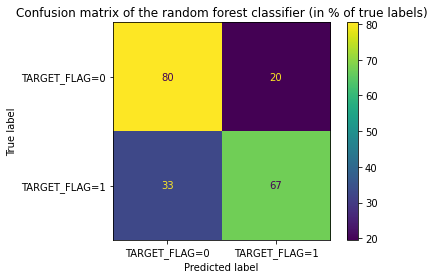

In [12]:
# First we return the percentage of good predictions
print("The precision of the random forest classifier is "+str(round(100*sum(predictions==y_test)/len(y_test),2))+"%")

# Then we plot the confusion matrix
cm=100*confusion_matrix(predictions,y_test,normalize="true") # To plot the results in percentage of the true labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["TARGET_FLAG=0","TARGET_FLAG=1"])
disp.plot()
disp.ax_.set_title("Confusion matrix of the random forest classifier (in % of true labels)")
plt.show()

#### Comments on the results

The overall classification results is okay for a classifier that was not optimized. The main problem of this classifier is
that it has a high rate of false negative (33% of all negative test data) which are the most risky errors for insurance 
companies because an accident occurs even though we predicted that it would not so it could cost them a lot of money. 

It makes sense that the performance of this algorithm is lower for true accidents as TARGET_FLAG=1 data only represents
25% of the total dataset.

### 4.2) Logistic regression classifier

In [13]:
# Another classic classifier model for binary classification is the logistic regression classifier, we will compare its
# performance with the random forest

from sklearn.linear_model import LogisticRegression
lrc=LogisticRegression()
lrc.fit(x_train, y_train)
predictions=lrc.predict(x_test)


The precision of the logistic regression classifier is 79.17%


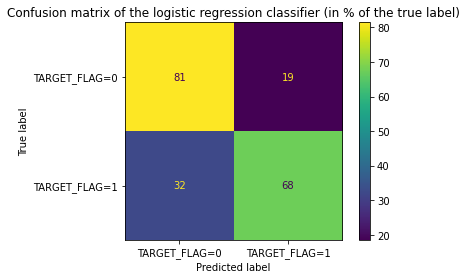

In [14]:
# First we return the percentage of good predictions
print("The precision of the logistic regression classifier is "+str(round(100*sum(predictions==y_test)/len(y_test),2))+"%")

# Then we plot the confusion matrix
cm=100*confusion_matrix(predictions,y_test,normalize="true") # To plot the results in percentage of the true labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["TARGET_FLAG=0","TARGET_FLAG=1"])
disp.plot()
disp.ax_.set_title("Confusion matrix of the logistic regression classifier (in % of the true label)")
plt.show()

#### Comments on the results
The logistic regressor performs slightly better than the random forest as the error rate went from 21.5% for random forest to 20.8% for the logistic regressor but the number of false negative is still too high.

### 4.3) Support Vector Classifier

In [15]:
from sklearn import svm
svc=svm.SVC() # Most classic SVM classifier of scikit learn
svc.fit(x_train,y_train)
predictions=svc.predict(x_test)

The precision of the Support Vector Classifier is 78.35%


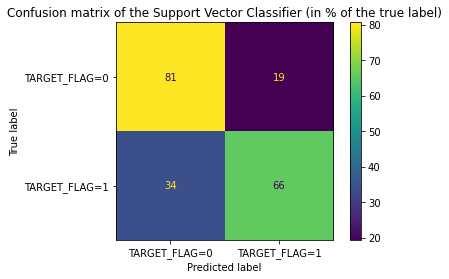

In [16]:
# First we return the percentage of good predictions
print("The precision of the Support Vector Classifier is "+str(round(100*sum(predictions==y_test)/len(y_test),2))+"%")

# Then we plot the confusion matrix
cm=100*confusion_matrix(predictions,y_test,normalize="true") # To plot the results in percentage of the true labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["TARGET_FLAG=0","TARGET_FLAG=1"])
disp.plot()
disp.ax_.set_title("Confusion matrix of the Support Vector Classifier (in % of the true label)")
plt.show()

#### Comments on the results
The SVC classifier has the lowest overall performance but also the highest rate of false negative, which is also a bad point, this algorithm should not be uses as is for the classification.

### 4.4) Model aggregation

In [17]:
# Random forest prediction

rfc = RandomForestClassifier(random_state=3) # We set the seed for reproductivity
rfc.fit(x_train, y_train)
rfc_predictions=rfc.predict(x_test)

# Logistic regression prediction

lrc=LogisticRegression()
lrc.fit(x_train, y_train)
lrc_predictions=lrc.predict(x_test)

# SVC prediction
svc=svm.SVC() 
svc.fit(x_train,y_train)
svc_predictions=svc.predict(x_test)

prediction_sum=rfc_predictions+lrc_predictions+svc_predictions
prediction_class=prediction_sum>1.5
prediction_class=prediction_class.astype(int)

The precision of the Support Vector Classifier is 78.76%


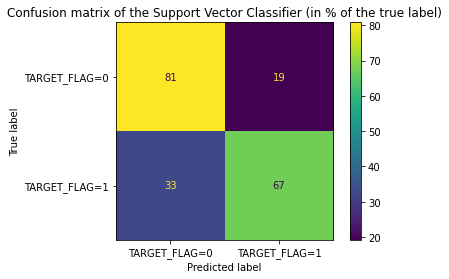

In [18]:
# First we return the percentage of good predictions
print("The precision of the Support Vector Classifier is "+str(round(100*sum(prediction_class==y_test)/len(y_test),2))+"%")

# Then we plot the confusion matrix
cm=100*confusion_matrix(prediction_class,y_test,normalize="true") # To plot the results in percentage of the true labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["TARGET_FLAG=0","TARGET_FLAG=1"])
disp.plot()
disp.ax_.set_title("Confusion matrix of the Support Vector Classifier (in % of the true label)")
plt.show()

#### Comments on the results
This aggregation of the models is note more performant then each one taken alone (one less good prediction than the logistic regression) but it will be more robust so we will use this one for the full prediction.

## 5) Predictions on the test set given in the problem

### 5.0) Getting the train set

In [19]:
# To get the best results possible the classifier will be trained on the whole train set rather then on the sub train set 
# that we used before.

y_train=cleaned_df["TARGET_FLAG"].values
large_train_set=cleaned_df.drop(["TARGET_FLAG","TARGET_AMT","INDEX"],axis=1)
x_train=preprocessing.StandardScaler().fit_transform(large_train_set)

### 5.1) Cleaning & encoding the test set

In [20]:
test_df_raw=pd.read_csv(test_file_path)

# First we remove the columns TARGET_FLAG & TARGET_AMT
test_df_raw.drop(["TARGET_FLAG","TARGET_AMT","INDEX"],axis=1,inplace=True)

# Then we use the same cleaning & encoding technique than before
test_df_noNaN=test_df_raw.copy()
test_df_noNaN.dropna(inplace=True)

dollard_columns=["INCOME","HOME_VAL","BLUEBOOK","OLDCLAIM"]
z_err_columns=["MSTATUS","SEX","EDUCATION","JOB","CAR_TYPE","URBANICITY"]

#Columns with values starting with $ sign are not int, to use thoes values we need to remove it
for column in dollard_columns:
    test_df_noNaN[column]=test_df_noNaN[column].str.lstrip("$")
    test_df_noNaN[column]=test_df_noNaN[column].str.replace(",","")
    test_df_noNaN[column]=test_df_noNaN[column].astype(int)
    
#Some of the values in the columns start with z_, to ease the understanding of the code we remove this prefix
for column in z_err_columns:
    test_df_noNaN[column]=test_df_noNaN[column].str.lstrip("z_")
    test_df_noNaN[column]=test_df_noNaN[column].astype(str)

In [21]:
# To treat the data, the model have to be fed int or float values and not str, we will 
# encode each str column with a number using scikit learn label encoder

test_df_int=test_df_noNaN.copy()

# The yes/no column will be converted to boolean

yes_no_columns=["PARENT1","MSTATUS","RED_CAR","REVOKED"]
for column in yes_no_columns:
    test_df_int[column]=test_df_int[column].str.lower() #Some columns had "Yes" and other "yes"
    test_df_int[column]=test_df_int[column].apply(lambda x : 1 if x=="yes" else 0)

# Encoding the str columns

str_columns=["SEX","EDUCATION","JOB","CAR_USE","CAR_TYPE","URBANICITY"]
for column in str_columns:
    encoded_column_name=column+"_encoded"
    le=preprocessing.LabelEncoder()
    test_df_int[encoded_column_name]=le.fit_transform(test_df_int[column])

# Now we remove the columns containing str and set all values types to int
cleaned_test_df=test_df_int.copy()
cleaned_test_df.drop(str_columns,axis=1,inplace=True)
for column in cleaned_test_df.columns:
    cleaned_test_df[column]=cleaned_test_df[column].astype(int)
    
cleaned_test_df=cleaned_test_df.sample(frac=1).reset_index(drop=True) 
x_test=cleaned_test_df.values
x_test=preprocessing.StandardScaler().fit_transform(x_test)

### 5.2) Model fitting & prediction

In [22]:
### Model aggregation ###
# As our 3 models all have relatively close performance, we will run all 3 of them for test and a majority vote will
# decide on the final classification (odd number of models to avoid tie votes)

In [23]:
# Random forest prediction

rfc = RandomForestClassifier(random_state=3) # We set the seed for reproductivity
rfc.fit(x_train, y_train)
rfc_predictions=rfc.predict(x_test)

# Logistic regression prediction

lrc=LogisticRegression()
lrc.fit(x_train, y_train)
lrc_predictions=lrc.predict(x_test)

# SVC prediction
svc=svm.SVC() 
svc.fit(x_train,y_train)
svc_predictions=svc.predict(x_test)

prediction_sum=rfc_predictions+lrc_predictions+svc_predictions
prediction_class=prediction_sum>1.5
prediction_class=prediction_class.astype(int)

### 5.3) Saving the output dataframe

In [24]:
# The results will be saved with the raw data
cleaned_test_df['TARGET_FLAG']=prediction_class
output_file_name=r"Predicted_results.csv"
output_file_path=os.path.join(folder_path,output_file_name)
cleaned_test_df.to_csv(output_file_path)

## 6) Conclusions and potential improvements

Our final method aggregating the 3 usual classifiers in supervized learning for binary output (Random forest, Logistic regression and Support Vector Machine Classifier) has **78.76% of good predictions**. This metric is not the one we should look at: a classifier returning 0 independently of the input value would anyway make 75% of good predictions as only 25% of the dataset is labeled with TARGET_FLAG=1. 

The important metric is rather the number of false negative predictions which represent losses for the insurance company (unpredicted accidents). Here, our model **predicts 67% of the accidents that actually occured** (TARGET_FLAG=1). 
Further improvement could be made on the cleaning of the dataset and on the training of the models to give more weight to the under-represented data where an accident occured. We could also improve the treatment of the NaN values in the input dataset, for example by replacing these values with the mean of the column concerned which would make the training set larger and allow more flexibility on the testing set. Finally, optimizing the hyperparameters could also allow us to improve the precisions of these models.